In [1]:
import os
import gc

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F


from lab1_proto import mfcc, mspec

from lab2_proto import *
from lab2_tools import *

from lab3_proto import *
from lab3_tools import *

np.random.seed(0)

In [2]:
TRAIN_DIR = "tidigits/disc_4.1.1/tidigits/train/"
TEST_DIR = "tidigits/disc_4.2.1/tidigits/test/"
TRAIN_DIR = os.path.relpath(TRAIN_DIR)
TEST_DIR = os.path.relpath(TEST_DIR)

DATASET_DIR = os.path.relpath("data")

In [16]:
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}

if not os.path.exists("stateList.txt"):
    stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
    with open("stateList.txt", "w") as f:
        for state in stateList:
            f.write(state + "\n")
else:
    with open("stateList.txt", "r") as f:
        stateList = f.read().splitlines()

" ".join(stateList)

'ah_0 ah_1 ah_2 ao_0 ao_1 ao_2 ay_0 ay_1 ay_2 eh_0 eh_1 eh_2 ey_0 ey_1 ey_2 f_0 f_1 f_2 ih_0 ih_1 ih_2 iy_0 iy_1 iy_2 k_0 k_1 k_2 n_0 n_1 n_2 ow_0 ow_1 ow_2 r_0 r_1 r_2 s_0 s_1 s_2 sil_0 sil_1 sil_2 sp_0 t_0 t_1 t_2 th_0 th_1 th_2 uw_0 uw_1 uw_2 v_0 v_1 v_2 w_0 w_1 w_2 z_0 z_1 z_2'

In [17]:
filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)

wordTrans = list(path2info(filename)[2])
" ".join(wordTrans)

'z 4 3'

In [18]:
from prondict import prondict

phoneTrans = words2phones(wordTrans, prondict)
" ".join(phoneTrans)

'sil z iy r ow sp f ao r sp th r iy sil'

In [19]:
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
" ".join(stateTrans)

'sil_0 sil_1 sil_2 z_0 z_1 z_2 iy_0 iy_1 iy_2 r_0 r_1 r_2 ow_0 ow_1 ow_2 sp_0 f_0 f_1 f_2 ao_0 ao_1 ao_2 r_0 r_1 r_2 sp_0 th_0 th_1 th_2 r_0 r_1 r_2 iy_0 iy_1 iy_2 sil_0 sil_1 sil_2'

C:\Users\elioc\AppData\Local\Temp\ipykernel_2296\188807043.py:4: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['startprob'][:-1]),
C:\Users\elioc\AppData\Local\Temp\ipykernel_2296\188807043.py:5: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['transmat'][:-1, :-1])


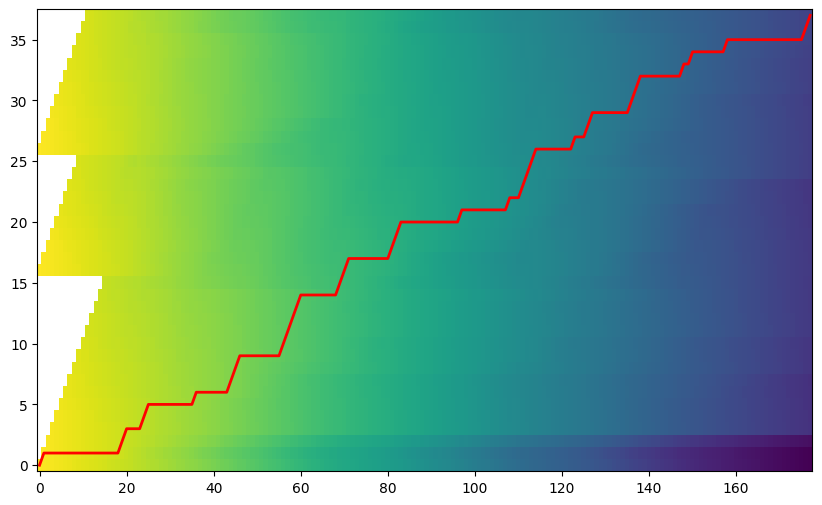

In [20]:
obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
v_loglik, path, log_V = viterbi(
    obsloglik,
    np.log(utteranceHMM['startprob'][:-1]),
    np.log(utteranceHMM['transmat'][:-1, :-1])
)

plt.figure(figsize=(10, 6))
plt.imshow(log_V.T, aspect='auto', interpolation='nearest', origin='lower')
plt.plot(np.arange(len(lmfcc)), path, color='red', linewidth=2)

# Align the state sequence with the MFCC frames using the viterbi path
viterbi_state_trans = [stateTrans[i] for i in path]
aligned = frames2trans(viterbi_state_trans).split("\n")
aligned = [a.split(" ") for a in aligned if a != ""]
aligned = [[float(a[0]), float(a[1]), a[2]] for a in aligned]

Text(0, 0.5, 'MFCC Coefficients')

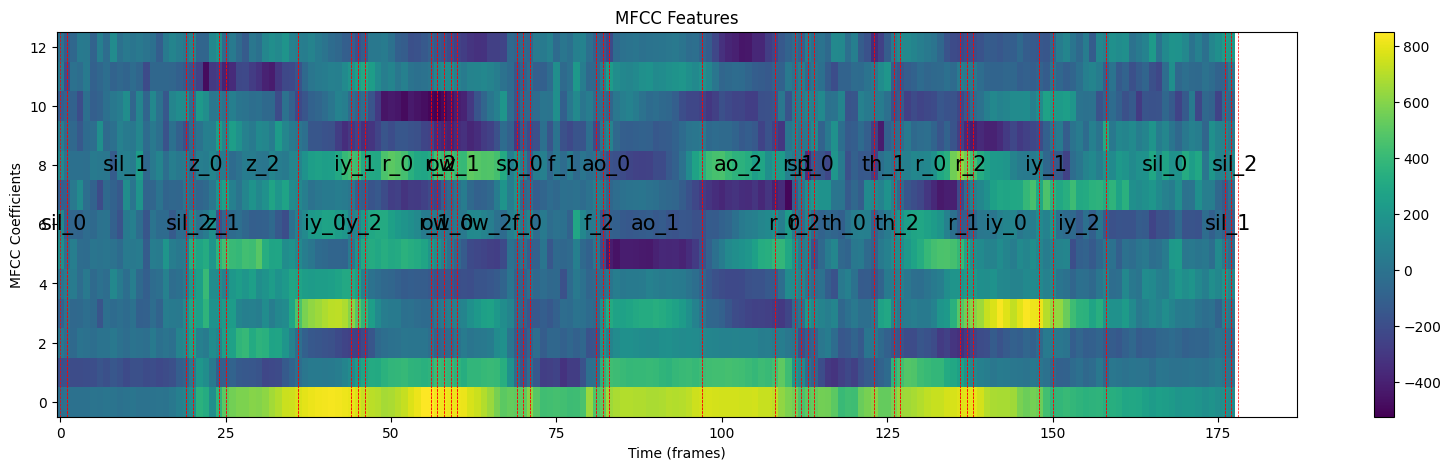

In [21]:
# Plot the MFCC features and the state alignment
plt.figure(figsize=(20, 5))
plt.imshow(lmfcc.T, aspect='auto', origin='lower')

for i, (start, end, state) in enumerate(aligned):
    start = int(start * samplingrate / 200)
    end = int(end * samplingrate / 200)
    plt.axvline(x=start, color='red', linestyle='--', linewidth=0.5)
    plt.axvline(x=end, color='red', linestyle='--', linewidth=0.5)
    plt.text((start + end) / 2, 6 + 2 * (i % 2), state, color='black', fontsize=15, ha='center', va='center')
    
plt.colorbar()
plt.title("MFCC Features")
plt.xlabel("Time (frames)")
plt.ylabel("MFCC Coefficients")

# 4.3 Feature Extraction

In [22]:
def make_dataset(folder, phoneHMMs, prondict, output_file="train_data.npz"):
    """
    Extract features from audio files in the given folder and save them to a numpy file.
    """
    data = []
    # Compute total number of files
    total_files = sum([len(files) for _, _, files in os.walk(folder) if files and files[0].endswith(".wav")])
    print(f"Total files to process: {total_files}")

    bar = tqdm(total=total_files, desc="Processing files", unit="file")
    for root, dir, files in os.walk(folder):
        for file in files:
            if file.endswith(".wav"):
                filename = os.path.join(root, file)
                samples, samplingrate = loadAudio(filename)
                lmfcc = mfcc(samples)
                mspecs = mspec(samples, samplingrate=samplingrate)
                
                wordTrans = list(path2info(filename)[2])
                phoneTrans = words2phones(wordTrans, prondict)
                stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
                
                utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
                
                states = forcedAlignment(
                    lmfcc,
                    utteranceHMM,
                    stateTrans,
                )
                states = [stateList.index(state) for state in states]
                
                data.append({
                    "filename": filename,
                    "lmfcc": lmfcc.astype(np.float32),
                    "mspec": mspecs.astype(np.float32),
                    "targets": states,
                })
            bar.update(1)
    bar.close()
    data = np.array(data)
    np.savez(output_file, data=data)



if not os.path.exists("train_data.npz"):
    print("Creating train_data.npz...")
    make_dataset(TRAIN_DIR, phoneHMMs, prondict, output_file="train_data.npz")
if not os.path.exists("test_data.npz"):
    print("Creating test_data.npz...")
    make_dataset(TEST_DIR, phoneHMMs, prondict, output_file="test_data.npz")

train_data = np.load("train_data.npz", allow_pickle=True)["data"]
test_data = np.load("test_data.npz", allow_pickle=True)["data"]

# 4.4 Training and Validation Sets

In [23]:
def select_speakers(n, target, speakerID, gender):
    """
    Select all samples from speakers of the target gender until we 
    reach n samples.
    There will likely be more than n samples selected since we select 
    all samples from a speaker.
    """
    unique = np.unique(speakerID[gender == target])
    res = []
    while len(res) < n:
        speaker_idx = np.random.randint(0, len(unique))
        speaker = unique[speaker_idx]
        # get all samples from this speaker
        samples = np.where(speakerID == speaker)
        res.extend(samples[0])
        # remove this speaker from the list of unique speakers
        unique = np.delete(unique, speaker_idx)
    return res

def split_train_val(data, val_size=0.1):
    """
    Split the dataset into training and validation sets.
    Make sure that there is a similar distribution of men and women in both sets, and that each
    speaker is only included in one of the two sets.
    """
    
    filenames = [s["filename"] for s in data]
    gender, speakerID, digits, repetition = zip(*[path2info(f) for f in filenames])
    
    gender, speakerID, digits, repetition = map(np.array, [gender, speakerID, digits, repetition]) 

    # Number of women/men samples
    n_women = np.sum(gender == "woman")
    n_men = len(gender) - n_women
    
    # How many samples to take for validation
    n_val_w = int(val_size * n_women)
    n_val_m = int(val_size * n_men)
    
    val_w = select_speakers(n_val_w, "woman", speakerID, gender)
    val_m = select_speakers(n_val_m, "man", speakerID, gender)

    val_idx = np.concatenate([val_w, val_m])
    train_idx = np.delete(np.arange(len(data)), val_idx)
    
    # Print a summary of the split including the number of samples in each set
    # and the gender distribution in each set
    print(f"Train set: {len(train_idx)} samples")
    print(f"Validation set: {len(val_idx)} samples")
    print(f"Train set gender distribution: {np.sum(gender[train_idx] == 'woman')} women samples, {np.sum(gender[train_idx] == 'man')} men samples")
    print(f"Train set gender distribution: {np.sum(gender[val_idx] == 'woman')} women samples, {np.sum(gender[val_idx] == 'man')} men samples")
    
    return data[train_idx], data[val_idx]
    
    
train_data, val_data = split_train_val(train_data, val_size=0.1)

Train set: 7699 samples
Validation set: 924 samples
Train set gender distribution: 3926 women samples, 3773 men samples
Train set gender distribution: 462 women samples, 462 men samples


### Save features without time context

In [24]:
lmfcc_train_x = np.concatenate([s["lmfcc"] for s in train_data], axis=0)
lmfcc_val_x = np.concatenate([s["lmfcc"] for s in val_data], axis=0)
lmfcc_test_x = np.concatenate([s["lmfcc"] for s in test_data], axis=0)

# Save as torch tensors in the "data" folder
os.makedirs("data", exist_ok=True)
torch.save(torch.from_numpy(lmfcc_train_x), "data/single_lmfcc_train_x.pt")
torch.save(torch.from_numpy(lmfcc_val_x), "data/single_lmfcc_val_x.pt")
torch.save(torch.from_numpy(lmfcc_test_x), "data/single_lmfcc_test_x.pt")

del lmfcc_train_x, lmfcc_val_x, lmfcc_test_x
gc.collect()


mspec_train_x = np.concatenate([s["mspec"] for s in train_data], axis=0)
mspec_val_x = np.concatenate([s["mspec"] for s in val_data], axis=0)
mspec_test_x = np.concatenate([s["mspec"] for s in test_data], axis=0)

torch.save(torch.from_numpy(mspec_train_x), "data/single_mspec_train_x.pt")
torch.save(torch.from_numpy(mspec_val_x), "data/single_mspec_val_x.pt")
torch.save(torch.from_numpy(mspec_test_x), "data/single_mspec_test_x.pt")

del mspec_train_x, mspec_val_x, mspec_test_x
gc.collect()

48

# 4.5 Acoustic Context (Dynamic Features)

In [25]:
def mirror_pad(n, i, k):
    if i < k:
        return np.concatenate((
            np.arange(1, k - i + 1)[::-1],
            np.arange(0, i + k + 1),
            )
        )
    if i >= n - k:
        return np.arange(n)[-mirror_pad(n, n - i - 1, k)[::-1]-1]

def stack_features(features, k=3):
    """
    Stack the features using a sliding window of size 2*k+1, with mirror padding.
    """
    stacked = []
    features = np.array(features)
    for i in range(len(features)):
        if i >= k and i < len(features) - k:
            idx = np.arange(i - k, i + k + 1)
        else:
            idx = mirror_pad(len(features), i, k)
        stacked.append(features[idx])
    return np.array(stacked)

def concat_flatten(features):
    """
    Concatenate the features and flatten them.
    """
    features = np.concatenate(features, axis=0)
    return features.reshape(-1, features.shape[1] * features.shape[2])

# 4.6 Feature Standardisation

In [26]:
from sklearn.preprocessing import StandardScaler

lmfcc_train_x = [stack_features(s["lmfcc"]) for s in tqdm(train_data)]
lmfcc_val_x = [stack_features(s["lmfcc"]) for s in tqdm(val_data)]
lmfcc_test_x = [stack_features(s["lmfcc"]) for s in tqdm(test_data)]

lmfcc_train_x = concat_flatten(lmfcc_train_x)
lmfcc_val_x = concat_flatten(lmfcc_val_x)
lmfcc_test_x = concat_flatten(lmfcc_test_x)

lmfcc_scaler = StandardScaler()
lmfcc_train_x = lmfcc_scaler.fit_transform(lmfcc_train_x)
lmfcc_val_x = lmfcc_scaler.transform(lmfcc_val_x)
lmfcc_test_x = lmfcc_scaler.transform(lmfcc_test_x)

np.savez("lmfcc.npz", lmfcc_train_x=lmfcc_train_x, 
         lmfcc_val_x=lmfcc_val_x, lmfcc_test_x=lmfcc_test_x,
         lmfcc_scaler=lmfcc_scaler
         )

print(f"lmfcc_train_x: {lmfcc_train_x.shape}")
print(f"lmfcc_val_x: {lmfcc_val_x.shape}")
print(f"lmfcc_test_x: {lmfcc_test_x.shape}")

del lmfcc_train_x, lmfcc_test_x, lmfcc_val_x, lmfcc_scaler
gc.collect()

100%|██████████| 8700/8700 [00:05<00:00, 1503.56it/s]


lmfcc_train_x: (1352455, 91)
lmfcc_val_x: (154937, 91)
lmfcc_test_x: (1527014, 91)


9

In [27]:
mspec_train_x = [stack_features(s["mspec"]) for s in tqdm(train_data)]
mspec_val_x = [stack_features(s["mspec"]) for s in tqdm(val_data)]
mspec_test_x = [stack_features(s["mspec"]) for s in tqdm(test_data)]

mspec_train_x = concat_flatten(mspec_train_x)
mspec_val_x = concat_flatten(mspec_val_x)
mspec_test_x = concat_flatten(mspec_test_x)

mspec_scaler = StandardScaler()
mspec_train_x = mspec_scaler.fit_transform(mspec_train_x)
mspec_val_x = mspec_scaler.transform(mspec_val_x)
mspec_test_x = mspec_scaler.transform(mspec_test_x)

np.savez("mspec.npz", mspec_train_x=mspec_train_x, 
         mspec_val_x=mspec_val_x, mspec_test_x=mspec_test_x, 
         mspec_scaler=mspec_scaler
         )

print(f"mspec_train_x: {mspec_train_x.shape}")
print(f"mspec_val_x: {mspec_val_x.shape}")
print(f"mspec_test_x: {mspec_test_x.shape}")

del mspec_test_x, mspec_train_x, mspec_val_x, mspec_scaler
gc.collect()

100%|██████████| 8700/8700 [00:07<00:00, 1099.29it/s]


mspec_train_x: (1352455, 280)
mspec_val_x: (154937, 280)
mspec_test_x: (1527014, 280)


9

In [30]:
train_y = [s["targets"] for s in tqdm(train_data)]
val_y = [s["targets"] for s in tqdm(val_data)]
test_y = [s["targets"] for s in tqdm(test_data)]

train_y = np.concatenate(train_y, axis=0)
val_y = np.concatenate(val_y, axis=0)
test_y = np.concatenate(test_y, axis=0)

train_y = F.one_hot(torch.from_numpy(train_y).long(), num_classes=len(stateList)).numpy()
val_y = F.one_hot(torch.from_numpy(val_y).long(), num_classes=len(stateList)).numpy()
test_y = F.one_hot(torch.from_numpy(test_y).long(), num_classes=len(stateList)).numpy()

print(f"train_y: {train_y.shape}")
print(f"val_y: {val_y.shape}")
print(f"test_y: {test_y.shape}")

np.savez("targets.npz", train_y=train_y, val_y=val_y, test_y=test_y)
del train_y, val_y, test_y
gc.collect()

100%|██████████| 8700/8700 [00:00<00:00, 1103363.72it/s]


train_y: (1352455, 61)
val_y: (154937, 61)
test_y: (1527014, 61)


2936

In [31]:
DATASET_DIR = "data"

def save_as_tensor(data, filename):
    """
    Save the data as a torch tensor.
    """
    print(f"Saving {filename}...")
    if os.path.exists(os.path.join(DATASET_DIR, filename)):
        print(f"{filename} already exists. Skipping.")
        return
    data = torch.from_numpy(data)
    torch.save(data, os.path.join(DATASET_DIR, filename))
    

lmfcc = np.load("lmfcc.npz", allow_pickle=True)
save_as_tensor(lmfcc["lmfcc_train_x"], "lmfcc_train_x.pt")
save_as_tensor(lmfcc["lmfcc_val_x"], "lmfcc_val_x.pt")
save_as_tensor(lmfcc["lmfcc_test_x"], "lmfcc_test_x.pt")
np.savez(os.path.join(DATASET_DIR, "lmfcc_scaler.npz"), lmfcc_scaler=lmfcc["lmfcc_scaler"])
del lmfcc # to free memory
gc.collect()

mspec = np.load("mspec.npz", allow_pickle=True)
save_as_tensor(mspec["mspec_train_x"], "mspec_train_x.pt")
save_as_tensor(mspec["mspec_val_x"], "mspec_val_x.pt")
save_as_tensor(mspec["mspec_test_x"], "mspec_test_x.pt")
np.savez(os.path.join(DATASET_DIR, "mspec_scaler.npz"), mspec_scaler=mspec["mspec_scaler"])
del mspec
gc.collect()

targets = np.load("targets.npz", allow_pickle=True)
save_as_tensor(targets["train_y"], "train_y.pt")
save_as_tensor(targets["val_y"], "val_y.pt")
save_as_tensor(targets["test_y"], "test_y.pt")
del targets
gc.collect()

Saving lmfcc_train_x.pt...
Saving lmfcc_val_x.pt...
Saving lmfcc_test_x.pt...
Saving mspec_train_x.pt...
Saving mspec_val_x.pt...
Saving mspec_test_x.pt...
Saving train_y.pt...
Saving val_y.pt...
Saving test_y.pt...


81

# 5. Phoneme Recognition with Deep Neural Networks

In [9]:
from train_models import MLPRelu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(model_name, input_size, output_size):
    """
    Load the model from the given file.
    """
    n = int(model_name.split("_")[-1][0])
    model_path = os.path.join('models', model_name+"_best_model.pt")
    model = MLPRelu(
        input_dim=input_size,
        output_dim=output_size,
        n_hidden=n)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    return model


def plot_run(model_name, ax, ymin, ymax):
    """
    Plot the loss and accuracy of the model during training.
    """
    run = np.load(os.path.join('models', model_name + "_run.npz"), allow_pickle=True)
    train_loss = run['train_losses']
    val_loss = run['val_losses']
    train_acc = run['train_accs']
    val_acc = run['val_accs']
    ax.plot(train_loss, label='Train Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_ylim(ymin, ymax)
    ax.legend(loc='upper left')
    ax.set_title(f"Model: {model_name}")

    # Plot accuracy on the same graph but with a different y-axis
    ax2 = ax.twinx()
    ax2.plot(train_acc, label='Train Accuracy', linestyle='--')
    ax2.plot(val_acc, label='Validation Accuracy', linestyle='--')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper right')    


def accuracy(model, X, y, batch_size=512):
    """
    Compute the accuracy of the model on the given data.
    """


def test_model(model_name, X_test, y_test):
    """
    Test the model on the test set and compute the accuracy and loss.
    """
    model = load_model(model_name, X_test.shape[1], y_test.shape[1])
    model.eval()
    
    loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_test, y_test),
        batch_size=256,
        shuffle=False,
    )
    acc = 0
    loss = 0
    criterion = nn.CrossEntropyLoss()
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        labels = torch.argmax(labels, dim=1)
        acc += (predicted == labels).sum().item()
        loss += loss.item()
    return acc / len(X_test), loss


ERROR! Session/line number was not unique in database. History logging moved to new session 113


In [10]:
for feature in ["lmfcc", "mspec", "single_lmfcc", "single_mspec"]:
    for n in [1, 4]:
        model_name = "{}_{}h".format(feature, n)
        print(f"Testing {model_name}...")
        X_test = torch.load(os.path.join(DATASET_DIR, f"{feature}_test_x.pt"))
        y_test = torch.load(os.path.join(DATASET_DIR, "test_y.pt"))
        acc, loss = test_model(model_name, X_test, y_test)
        print(f"Accuracy: {acc:.4f}, Loss: {loss:.4f}")
        print(f"Model: {model_name} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")
        print("-" * 50)
        

Testing lmfcc_1h...
Accuracy: 0.6785, Loss: 1.2957
Model: lmfcc_1h - Accuracy: 0.6785, Loss: 1.2957
--------------------------------------------------
Testing lmfcc_4h...
Accuracy: 0.6921, Loss: 1.6176
Model: lmfcc_4h - Accuracy: 0.6921, Loss: 1.6176
--------------------------------------------------
Testing mspec_1h...
Accuracy: 0.6721, Loss: 1.4181
Model: mspec_1h - Accuracy: 0.6721, Loss: 1.4181
--------------------------------------------------
Testing mspec_4h...
Accuracy: 0.6906, Loss: 2.3281
Model: mspec_4h - Accuracy: 0.6906, Loss: 2.3281
--------------------------------------------------
Testing single_lmfcc_1h...
Accuracy: 0.5277, Loss: 3.2187
Model: single_lmfcc_1h - Accuracy: 0.5277, Loss: 3.2187
--------------------------------------------------
Testing single_lmfcc_4h...
Accuracy: 0.5390, Loss: 2.7500
Model: single_lmfcc_4h - Accuracy: 0.5390, Loss: 2.7500
--------------------------------------------------
Testing single_mspec_1h...
Accuracy: 0.5458, Loss: 3.1510
Model: s

Testing lmfcc_1h...
Accuracy: 0.6785, Loss: 1.2957
Model: lmfcc_1h - Accuracy: 0.6785, Loss: 1.2957

Testing lmfcc_4h...
Accuracy: 0.6921, Loss: 1.6176
Model: lmfcc_4h - Accuracy: 0.6921, Loss: 1.6176

Testing mspec_1h...
Accuracy: 0.6721, Loss: 1.4181
Model: mspec_1h - Accuracy: 0.6721, Loss: 1.4181

Testing mspec_4h...
Accuracy: 0.6906, Loss: 2.3281
Model: mspec_4h - Accuracy: 0.6906, Loss: 2.3281

Testing single_lmfcc_1h...
Accuracy: 0.5277, Loss: 3.2187
Model: single_lmfcc_1h - Accuracy: 0.5277, Loss: 3.2187

Testing single_lmfcc_4h...
Accuracy: 0.5390, Loss: 2.7500
Model: single_lmfcc_4h - Accuracy: 0.5390, Loss: 2.7500

Testing single_mspec_1h...
Accuracy: 0.5458, Loss: 3.1510
Model: single_mspec_1h - Accuracy: 0.5458, Loss: 3.1510

Testing single_mspec_4h...
Accuracy: 0.5578, Loss: 2.5935
Model: single_mspec_4h - Accuracy: 0.5578, Loss: 2.5935

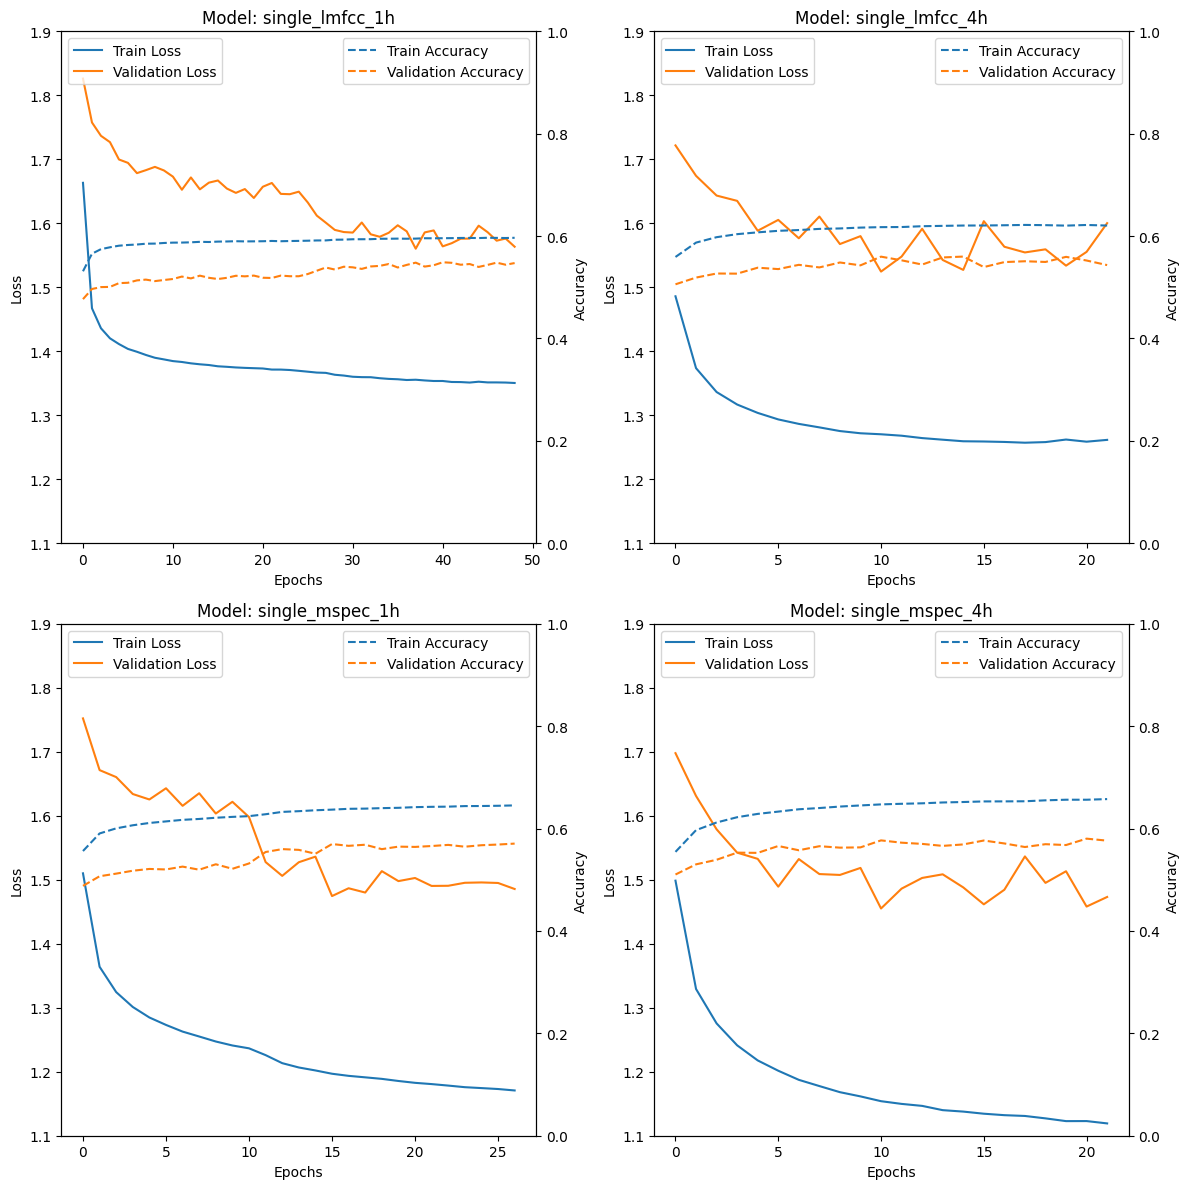

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, feature in enumerate(["single_lmfcc", "single_mspec"]):
    for j, n in enumerate([1, 4]):
        model_name = "{}_{}h".format(feature, n)
        ax = axes[i * 2 + j]
        plot_run(model_name, ax, 1.1, 1.9)
plt.tight_layout()
plt.show()

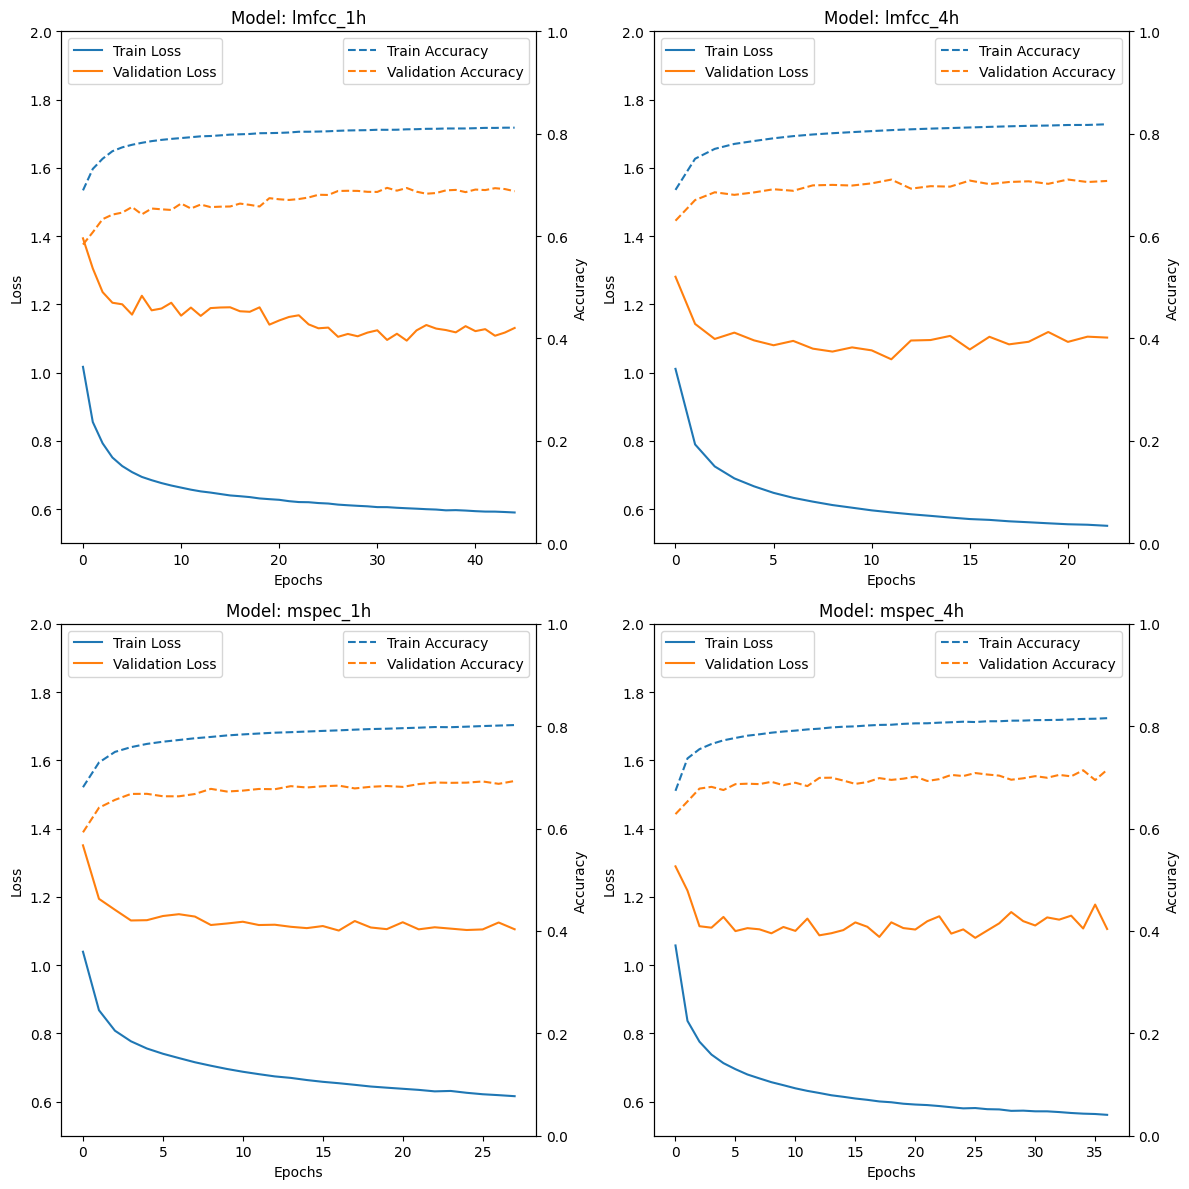

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, feature in enumerate(["lmfcc", "mspec"]):
    for j, n in enumerate([1, 4]):
        model_name = "{}_{}h".format(feature, n)
        ax = axes[i * 2 + j]
        plot_run(model_name, ax, 0.5, 2)
plt.tight_layout()
plt.show()